In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

In [9]:
def generate_sample_data():
    # Generate sample data
    np.random.seed(42)  # For reproducibility
    # Generate dates
    start_date = datetime(2000, 1, 1)
    end_date = datetime(2023, 12, 31)
    dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
    # Generate ISINs and CUSIPs
    isins = ['ISIN001', 'ISIN002', 'ISIN003']
    cusips = ['CUSIP001', 'CUSIP002', 'CUSIP003']
    # Generate random prices, modified duration, and Z-spread
    data = []
    for date in dates:
        for isin in isins:
            price = np.random.uniform(90, 110)
            moddur_m = np.random.uniform(1, 10)
            zsprd_m = np.random.uniform(1, 1500)
            data.append([date.strftime('%Y%m%d'), isin, None, price, moddur_m, zsprd_m])
        for cusip in cusips:
            price = np.random.uniform(90, 110)
            moddur_m = np.random.uniform(1, 10)
            zsprd_m = np.random.uniform(1, 1500)
            data.append([date.strftime('%Y%m%d'), None, cusip, price, moddur_m, zsprd_m])
    # Create DataFrame
    columns = ['Date', 'ISIN', 'CUSIP', 'PRICE', 'MODDUR_M', 'ZSPRD_M']
    df = pd.DataFrame(data, columns=columns)
    return df

def dataset(df, identifier, mpr):
    """
    Preprocess the dataset based on the identifier (ISIN or CUSIP) and calculate the return (RT).
    """
    if identifier == 'ISIN':
        df = df[['Date', 'ISIN', 'PRICE', 'MODDUR_M', 'ZSPRD_M']].dropna()
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.date
        df.set_index(['Date', 'ISIN'], inplace=True)
        df['RT'] = df.groupby('ISIN')['PRICE'].pct_change(mpr)
        df = df.dropna()
    elif identifier == 'CUSIP':
        df = df[['Date', 'CUSIP', 'PRICE', 'MODDUR_M', 'ZSPRD_M']].dropna()
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.date
        df.set_index(['Date', 'CUSIP'], inplace=True)
        df['RT'] = df.groupby('CUSIP')['PRICE'].pct_change(mpr)
        df = df.dropna()
    return df


In [12]:
data = generate_sample_data()
data_set = dataset(data, "CUSIP", 5)

# Extract the relevant columns
X = data_set[['MODDUR_M', 'ZSPRD_M']].values
y = data_set['RT'].values

# Add a constant for the intercept
X = sm.add_constant(X)

# Split into training and out-of-sample data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:
def quantile_regression(X, y, quantile=0.5):
    """
    Perform quantile regression using statsmodels.
    """
    model = sm.QuantReg(y, X)
    results = model.fit(q=quantile)
    return results

In [15]:
# Number of bootstrap samples
n_bootstrap = 1000

# Quantile for regression (99%)
quantile = 0.99

# Store bootstrap coefficients
bootstrap_coeffs = []

for _ in range(n_bootstrap):
    # Sample with replacement
    sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_sample = X_train[sample_indices]
    y_sample = y_train[sample_indices]
    
    # Fit quantile regression
    results = quantile_regression(X_sample, y_sample, quantile=quantile)
    
    # Store coefficients
    bootstrap_coeffs.append(results.params)

# Convert to numpy array
bootstrap_coeffs = np.array(bootstrap_coeffs)

In [16]:
# Calculate mean and 95% credible intervals for the coefficients
mean_coeffs = np.mean(bootstrap_coeffs, axis=0)
lower_coeffs = np.percentile(bootstrap_coeffs, 2.5, axis=0)
upper_coeffs = np.percentile(bootstrap_coeffs, 97.5, axis=0)

# Print results
print("Mean coefficients:", mean_coeffs)
print("95% Credible Intervals:")
for i, (lower, upper) in enumerate(zip(lower_coeffs, upper_coeffs)):
    print(f"Coefficient {i}: [{lower}, {upper}]")

Mean coefficients: [1.84765254e-01 3.20934554e-05 3.91438720e-06]
95% Credible Intervals:
Coefficient 0: [0.17757555853296753, 0.1910596526964029]
Coefficient 1: [-0.0008208495633339529, 0.0008357593488281505]
Coefficient 2: [-1.2529670627027225e-06, 9.235726141059512e-06]


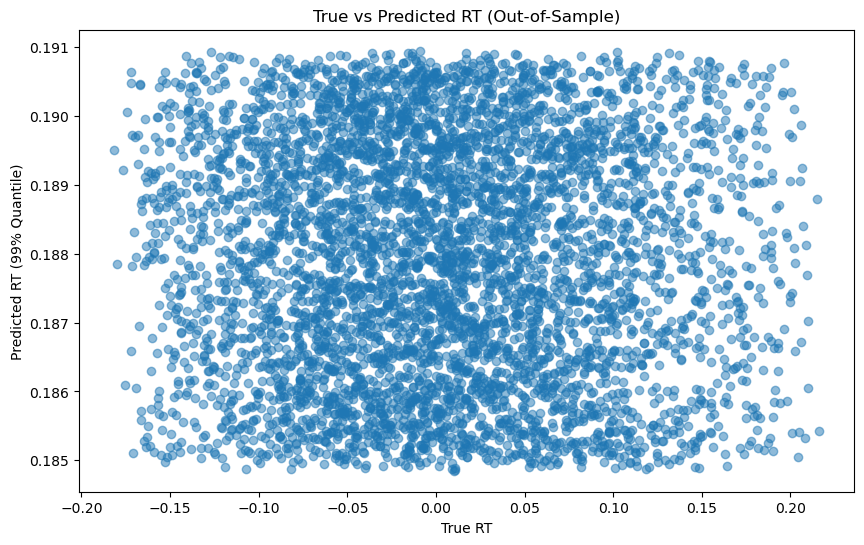

In [17]:
# Predict using the mean coefficients
predicted_rt = np.dot(X_test, mean_coeffs)

# Plot the true vs predicted RT
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_rt, alpha=0.5)
plt.xlabel("True RT")
plt.ylabel("Predicted RT (99% Quantile)")
plt.title("True vs Predicted RT (Out-of-Sample)")
plt.show()

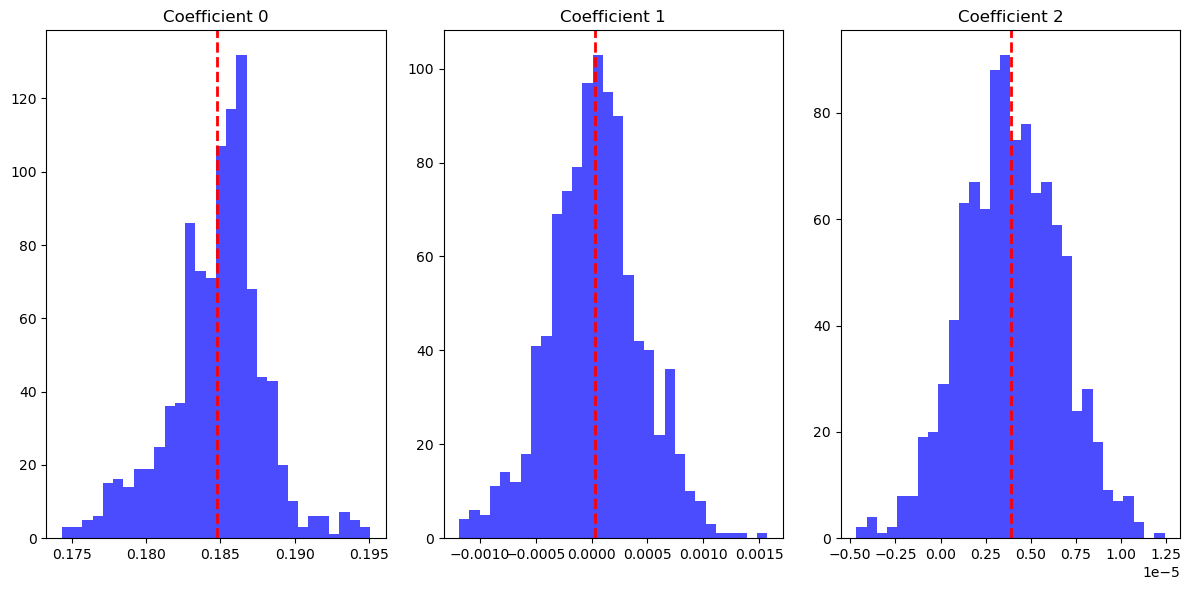

In [18]:
# Plot the posterior distribution of the coefficients
plt.figure(figsize=(12, 6))
for i in range(bootstrap_coeffs.shape[1]):
    plt.subplot(1, bootstrap_coeffs.shape[1], i + 1)
    plt.hist(bootstrap_coeffs[:, i], bins=30, alpha=0.7, color='blue')
    plt.axvline(mean_coeffs[i], color='red', linestyle='dashed', linewidth=2)
    plt.title(f"Coefficient {i}")
plt.tight_layout()
plt.show()